# Real-time $R_t$ computation on Italian COVID-19 data, by Stefano Terna$^1$

$^1$ PhD String Theory, [tomorrowdata.io](https://tomorrowdata.io) CEO

## Citations

1. Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases, Luı´s M. A. Bettencourt, Ruy M. Ribeiro, [paper](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0002185&type=printable)
2. A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, Anne Cori, Neil M. Ferguson, Christophe Fraser, and Simon Cauchemez, [paper and supplementary data](https://academic.oup.com/aje/article/178/9/1505/89262)
3. Numero di riproduzione netto al tempo t, [Wikipedia](https://it.wikipedia.org/wiki/Numero_di_riproduzione_di_base#Numero_di_riproduzione_netto_al_tempo_t) 
4. FAQ sul calcolo del Rt, Istituto Superiore di Sanità, [link](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt)
5. Lockdown Can’t Last Forever. Here’s How to Lift It, Gabriel Leung, University of Hong Kong, [New York Times](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) 
6. Azienda sanitaria dell’Alto Adige, [Risultati](https://coronatest.sabes.it/it/muni) dello Screening a livello provinciale per il contenimento del Coronavirus
7. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 novembre 2020
8. Tikhonov regularization, [Wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization)
9. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 agosto 2020
10. Dati COVID-19 Italia, Protezione Civile, [github](https://github.com/pcm-dpc/COVID-19)
11. "Monitoraggio settimanale - Ministero della Salute" check [here](http://www.salute.gov.it/portale/nuovocoronavirus/archivioNotizieNuovoCoronavirus.jsp?lingua=italiano&tipo=Report+settimanale+Covid-19&btnCerca=cerca) for new weekly updates.
12. "Monitoraggio settimale" by Istituto Superiore di Sanità, detailed reports, [here](https://www.iss.it/monitoraggio-settimanale)

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [2]:
import os
import locale
locale.setlocale(locale.LC_TIME, "it_IT.UTF8")
from datetime import datetime, timedelta
from matplotlib import pyplot as plt, dates as mdates
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.utils import smape, padnan, RSVD_smooth_data_generic

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
date_ = os.environ.get("REF_DATE")
if date_ is None:
    date_ = "2022-03-25"
print(date_)

2022-04-01


In [4]:
pastdays='000'

## Rt gamma parameters:

In [5]:
alpha = 1.87
beta = 0.28

ALPHA=100.

## Load DPC data, smooth them and compute naive Rt

In [6]:
DPC_data = DPC.load_daily_cases_from_github()
TIMESTEPS, FIRST_CASI_SOSP_DIAGNOSTICO = DPC.preprocess(DPC_data)
DPC.compute_first_diffs(DPC_data)
regularizer = TikhonovRegularization(timesteps=TIMESTEPS, alpha=ALPHA)
DPC.tikhonov_smooth_differentiate(DPC_data, regularizer)
DPC.bulk_compute_naive_Rt(DPC_data, alpha=alpha, beta = beta)

https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv
{   'deceduti_giornalieri': 'deceduti',
    'dimessi_guariti_giornalieri': 'dimessi_guariti',
    'nuovi_casi_da_screening': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati': 'hospitalized_cumulative',
    'tamponi_giornalieri': 'tamponi'}
{   'deceduti_giornalieri_smoothed': 'deceduti',
    'dimessi_guariti_giornalieri_smoothed': 'dimessi_guariti',
    'nuovi_casi_da_screening_smoothed': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico_smoothed': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati_smoothed': 'hospitalized_cumulative',
    'nuovi_positivi_smoothed': 'totale_casi',
    'tamponi_giornalieri_smoothed': 'tamponi'}
tamponi_giornalieri_smoothed - TIC R2: 0.9999978844824668
dimessi_guariti_giornalieri_smoothed - TIC R2: 0.9999947226451305
deceduti_giornalieri_smoothed

# Use RSVD: Regularized Singular Value Decomposition

RSVD allows to detect the seasonal component of the signal.

In the case of DPC `nuovi_positivi` we have a **weekly seasonality**, hence `season_period = 7`

RSVD has been proposed by Wei Lin, Jianhua Huang (Texas A&M University), Tucker Mcelroy (U.S. Census Bureau), in this [paper](https://www.researchgate.net/publication/327256122_Time_Series_Seasonal_Adjustment_Using_Regularized_Singular_Value_Decomposition)

It essentially casts the signal vector into a matrix whose columns are the seasons and the rows are the repetitive periods of a complete series of seasons. In our case the matrix shape will be `(~len(signal) / 7, 7)`.
Singular Value Decomposition is applied to the matrix so that singular values represent the seasonal component of the signal. Each (7 in our case) seasonal component is regularized via Tikhonov, following the hypotheis that each season component, period after period, must change smoothly. The Tikhonov regularization paramether is fitted via "leave one out cross validation".

The advantage of this method with respect to the SARIMA approach is that **we don't need to take moving averages**, and we don't need to tune any metaparameter of the model.

We wrote the python porting of the original R code.
The python porting is available from the following namespace:
```
import covid19_pytoolbox.smoothing.seasonalRSVD
```

The following features have been added to the original work:
- RSVD is applied by means of two different classes:
  - `SeasonalRegularizer` applies RSVD to the plain data
  - `LogSeasonalRegularizer` applies RSVD on the logarithm of the data to remove exponential trends; the inverse functions are correctly applied before returning the outputs, to remove the effects of taking the logarithm on the original signal
- both classes accept a `difference_degree` parameters; if greater then 0, the `n-th = difference_degree` difference is taken on the original signal prior to apply RSVD; this is helpful to remove non-stationarity in the original data
- the `adfuller` test can be performed on the input data to check (manually) if any non-stationary component is present
- the Tikhonov regularized trend is extracted from the deseasoned signal
- residuals are computed as differences between the deseasoned signal and the smoothed trend; relative residuals are also computed by the `LogSeasonalRegularizer`
- the signal is left truncated to obtain the RSVD matrix; before returning, the outputs are padded with `np.nan` to the left, to rebuild the original vector shape


In [7]:
DPC.RSVD_smooth_data(DPC_data, alpha=alpha, beta=beta, difference_degree=2, trend_alpha=ALPHA)

[   'nuovi_positivi',
    'tamponi_giornalieri',
    'nuovi_ospedalizzati',
    'deceduti_giornalieri',
    'ingressi_terapia_intensiva']
nuovi_positivi_deseason
info_cri:  -2.5922371279207965
info_cri:  -1.4755718815360215
TIC R2: 0.996032088887061
patterns: 1
(   -8.116259923980468,
    1.188748275755212e-12,
    20,
    747,
    {   '1%': -3.439134355513998,
        '10%': -2.56883447171999,
        '5%': -2.865416893922985},
    -546.2178856019277)
new columns generated:
[   'nuovi_positivi_deseason',
    'nuovi_positivi_deseason_seasonality',
    'nuovi_positivi_deseason_smoothed',
    'nuovi_positivi_deseason_residuals',
    'nuovi_positivi_deseason_relative_residuals',
    'nuovi_positivi_deseason_smoothed_Rt']
tamponi_giornalieri_deseason
info_cri:  -2.554830273512379
info_cri:  -0.8367299963585826
TIC R2: 0.9849386725255718
patterns: 1
(   -10.420622087365507,
    1.7084639103457717e-18,
    20,
    747,
    {   '1%': -3.439134355513998,
        '10%': -2.56883447171999,
     

## Plotting the signal after applying RSVD

- the blue line is the original signal
- the violet line represent the oscillating seasonal component
- the orange line is the deseasoned signal
  - we can see how the orange line is much less oscillating with respect to the blue one, as RSVD succeded in removing the seasonal component
- the red line represents the smoothed trend of the deseasoned signal

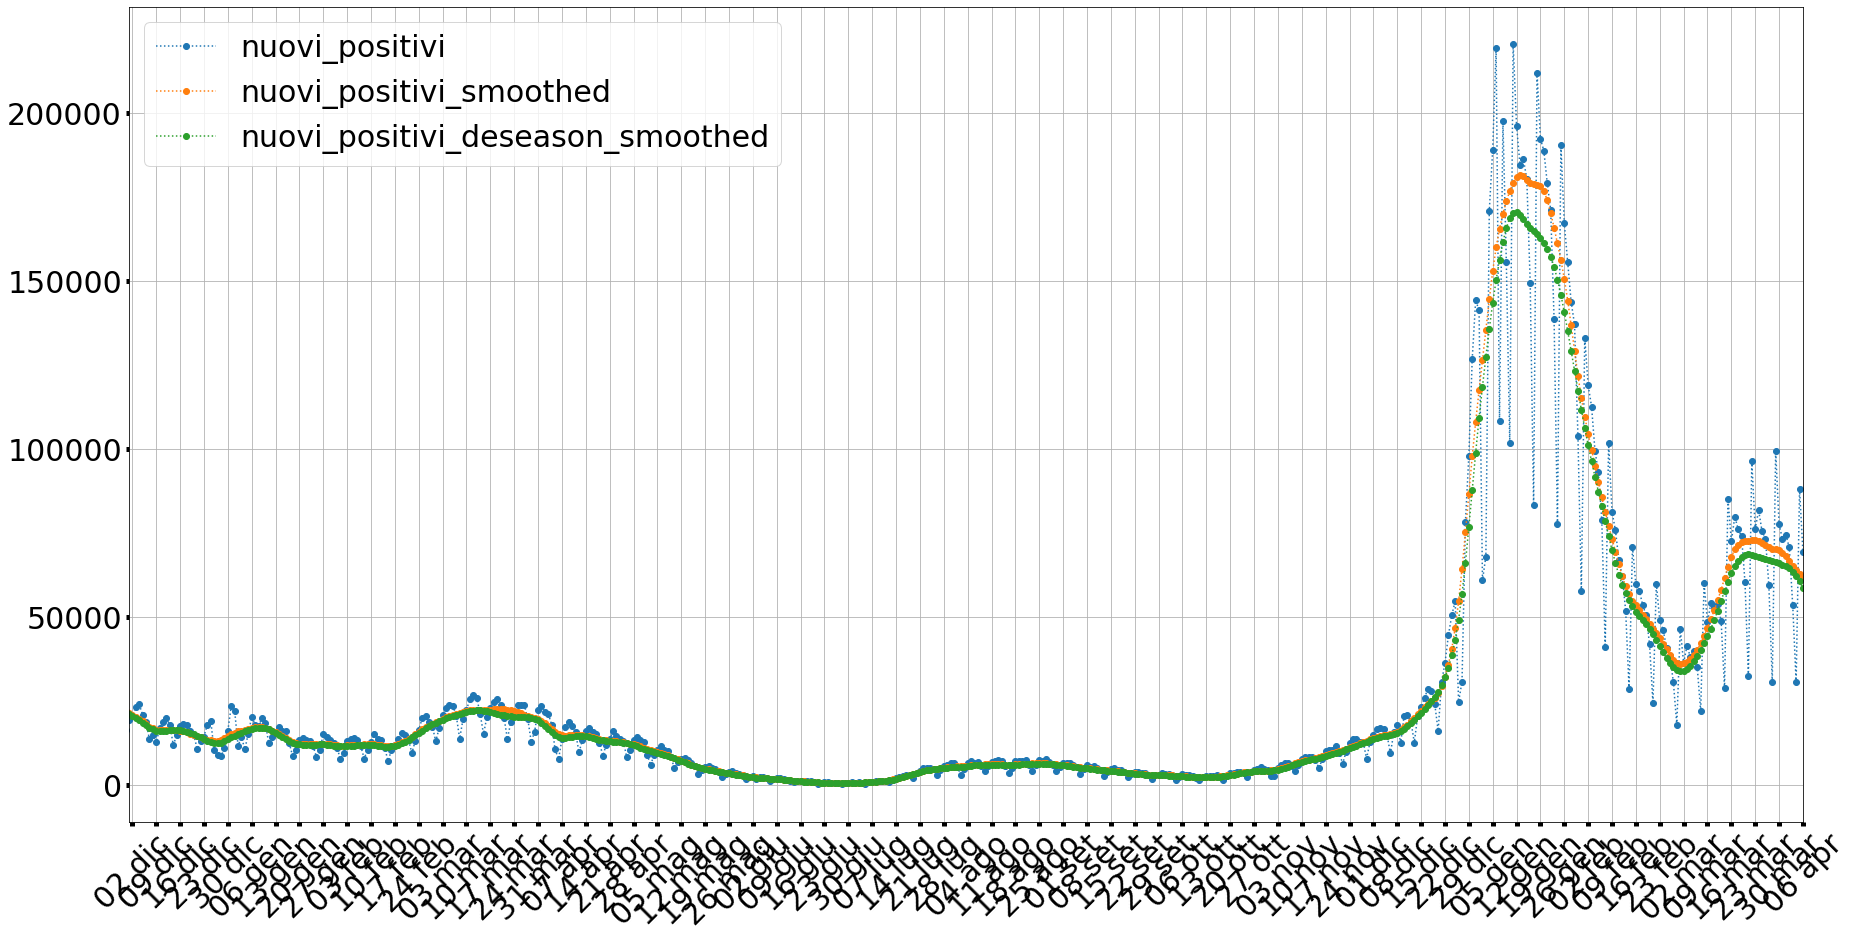

In [8]:
plotting.plot_series(
    df=DPC_data,
    yfields=[
        'nuovi_positivi', 
        'nuovi_positivi_smoothed',
        'nuovi_positivi_deseason_smoothed'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2020,12,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

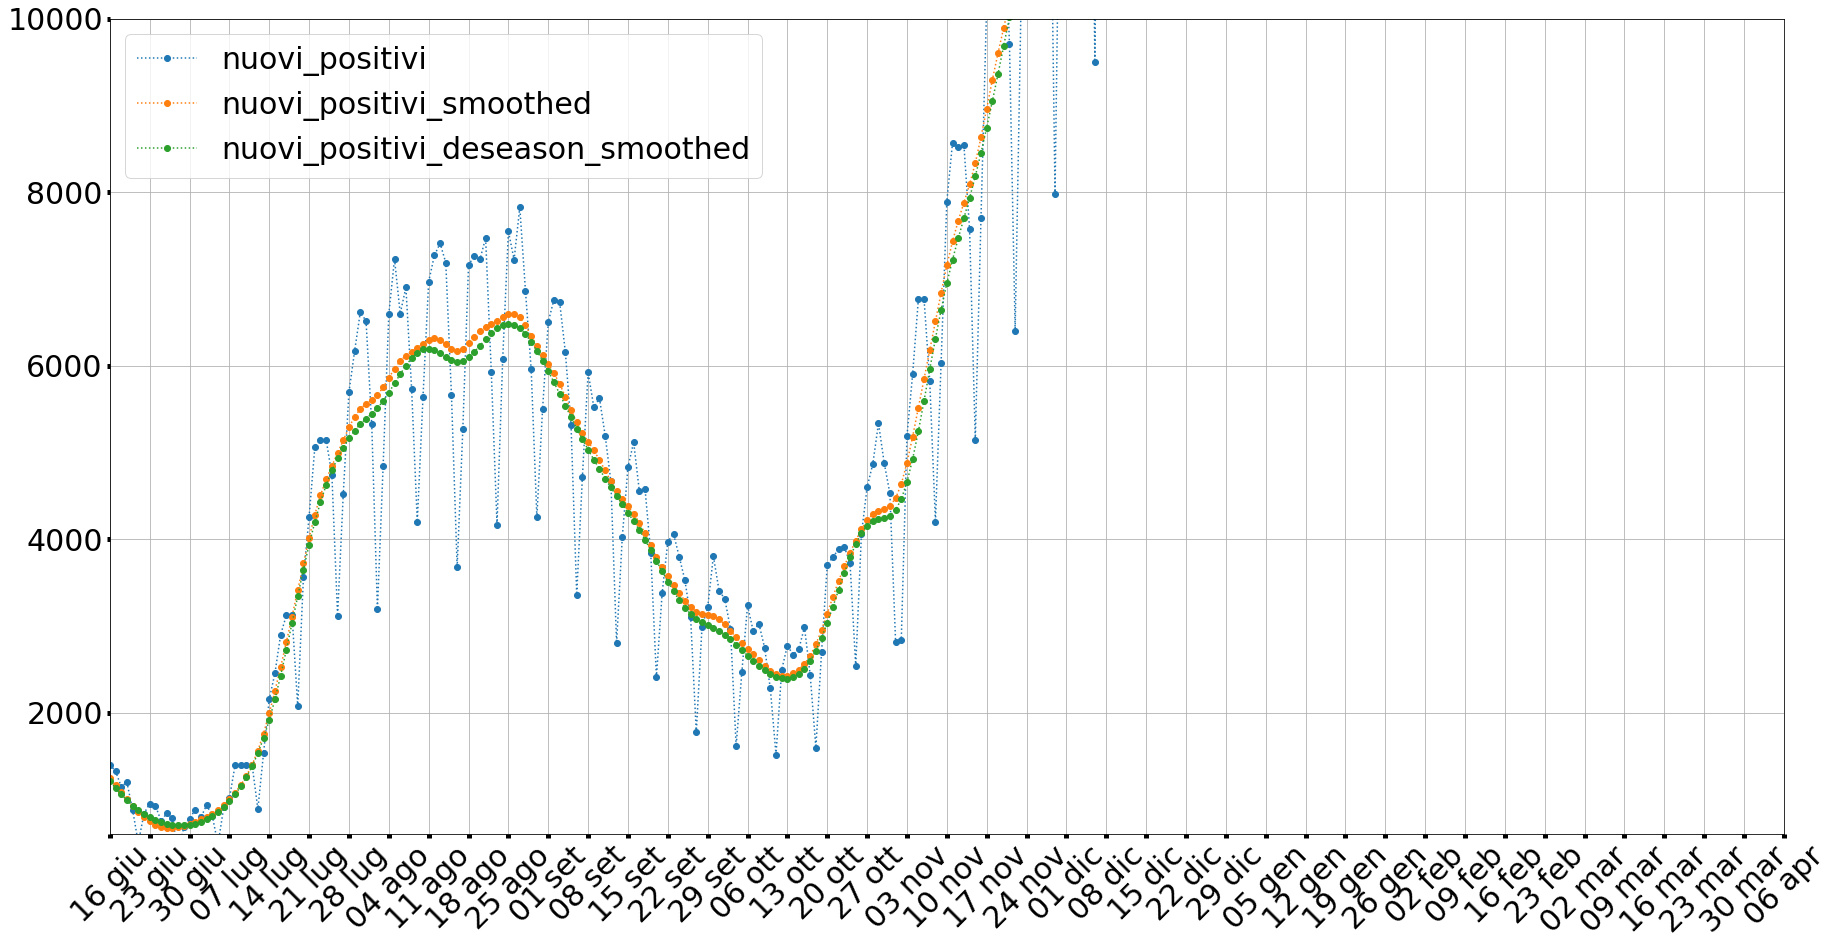

In [9]:
plotting.plot_series(
    df=DPC_data,
    yfields=[
        'nuovi_positivi', 
        'nuovi_positivi_smoothed',
        'nuovi_positivi_deseason_smoothed'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    ylim=(600,10000),
    xlim=(datetime(2021,6,16), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

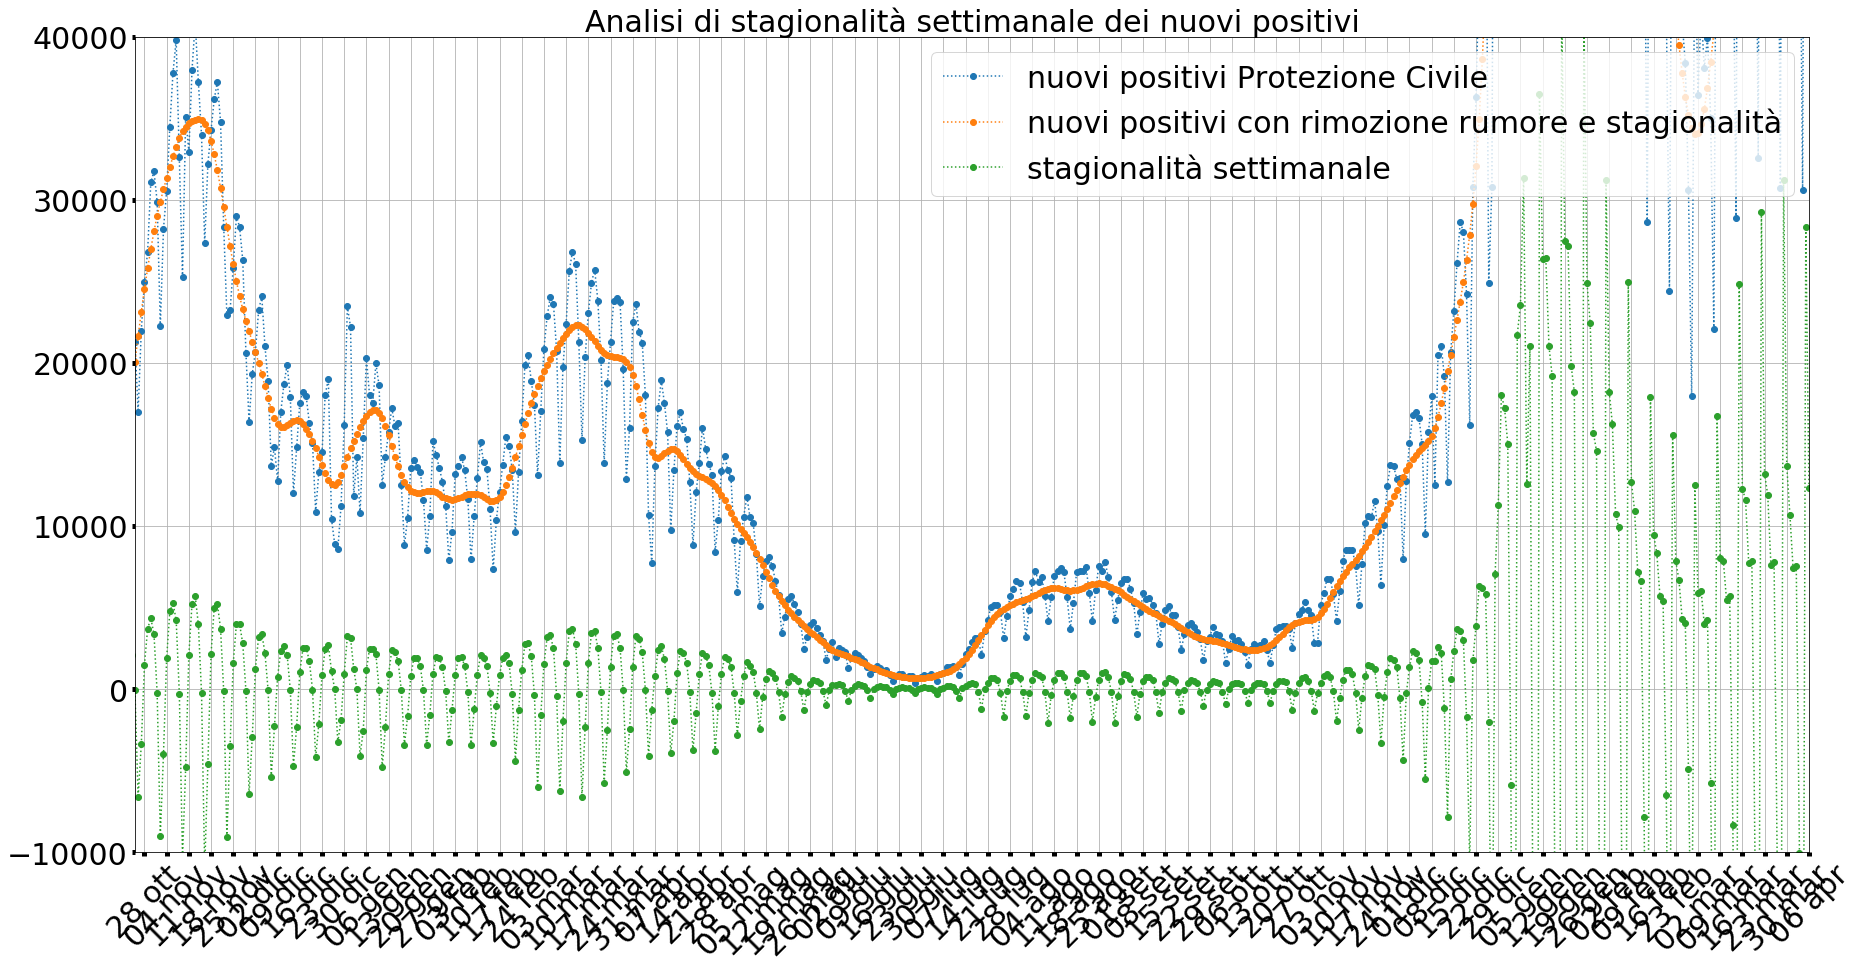

In [10]:
plotting.plot_series(
    title='Analisi di stagionalità settimanale dei nuovi positivi',
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi', 
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_deseason_seasonality'
        ],
        'labels': [
            'nuovi positivi Protezione Civile',
            'nuovi positivi con rimozione rumore e stagionalità',
            'stagionalità settimanale'
        ]
    }],
    xlim=(datetime(2020,10,25), DPC_data.data.max()),
    ylim=(-10000,40000),
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/nuovi_casi'),
    legend_loc="upper right"
)

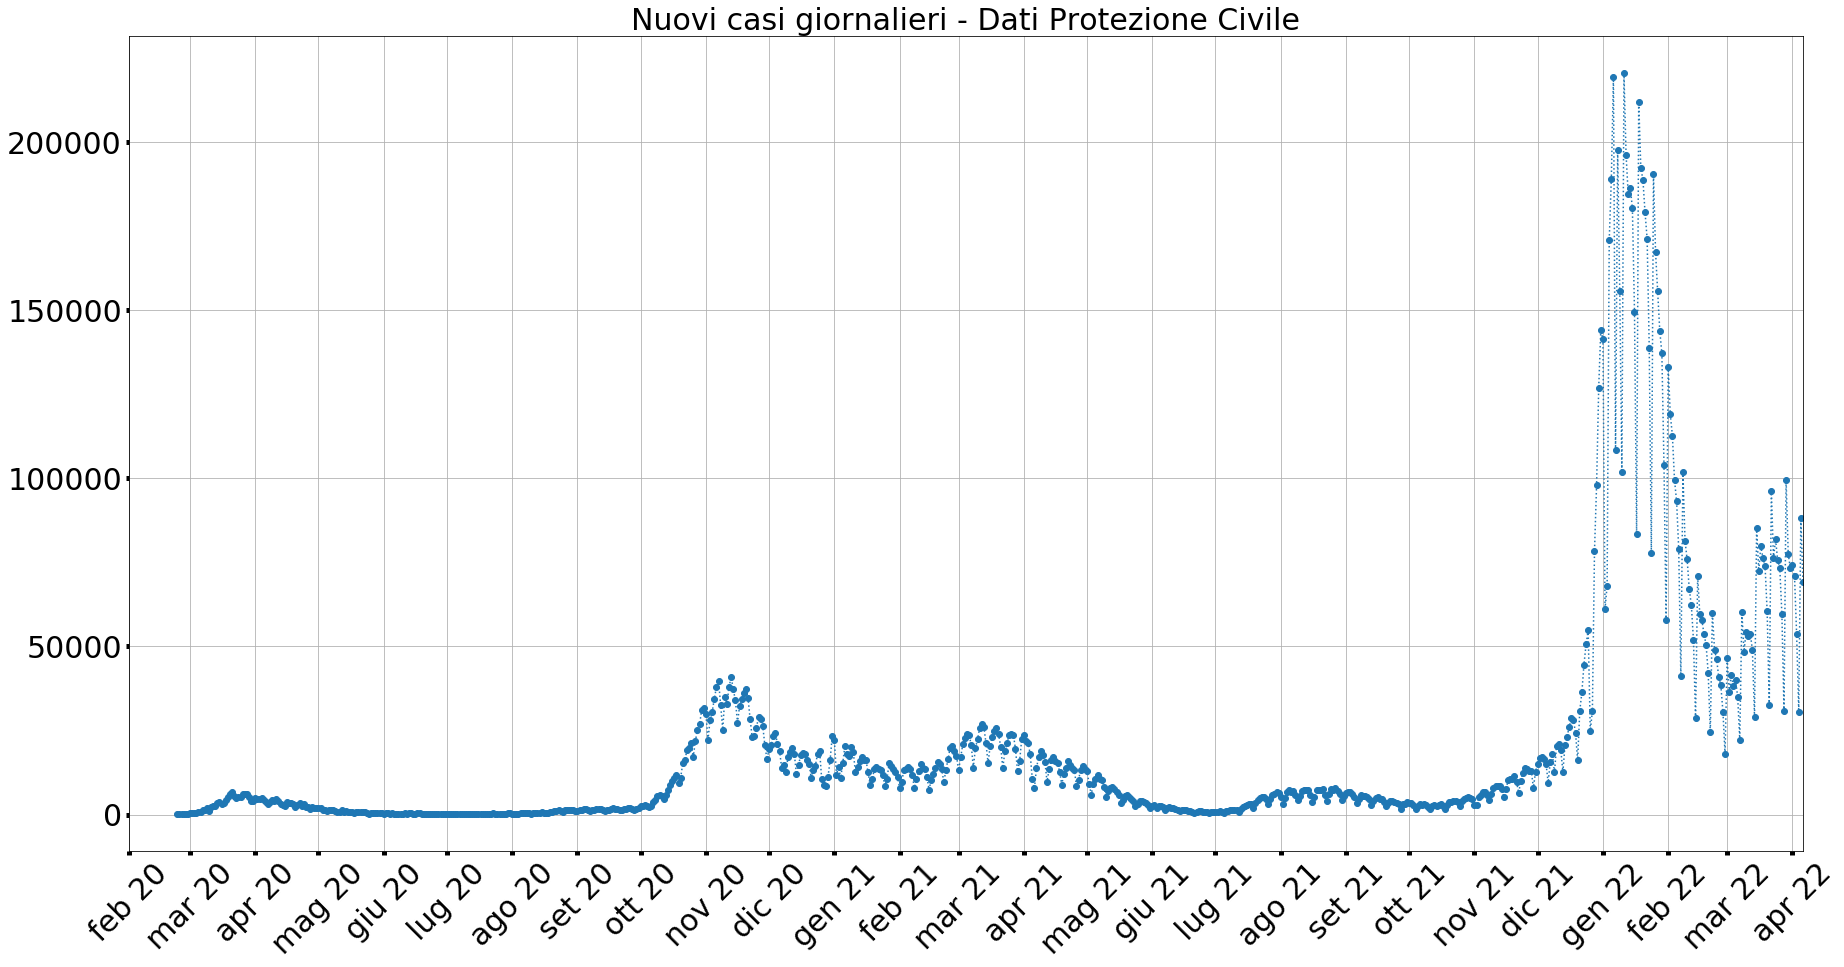

In [11]:
plotting.plot_series(
    title='Nuovi casi giornalieri - Dati Protezione Civile',
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi', 
        ],
        'labels': [
            'nuovi positivi Protezione Civile',
            'nuovi positivi con rimozione rumore e stagionalità',
            'stagionalità settimanale'
        ]
    }],
    xlim=(datetime(2020,2,1), DPC_data.data.max()),
#    ylim=(-10000,40000),
#    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/nuovi_casi'),
    legend_loc="upper right",
    major_formatter=mdates.DateFormatter("%b %y"),
    major_locator=mdates.MonthLocator(bymonthday=1),
    legend_on=False
)

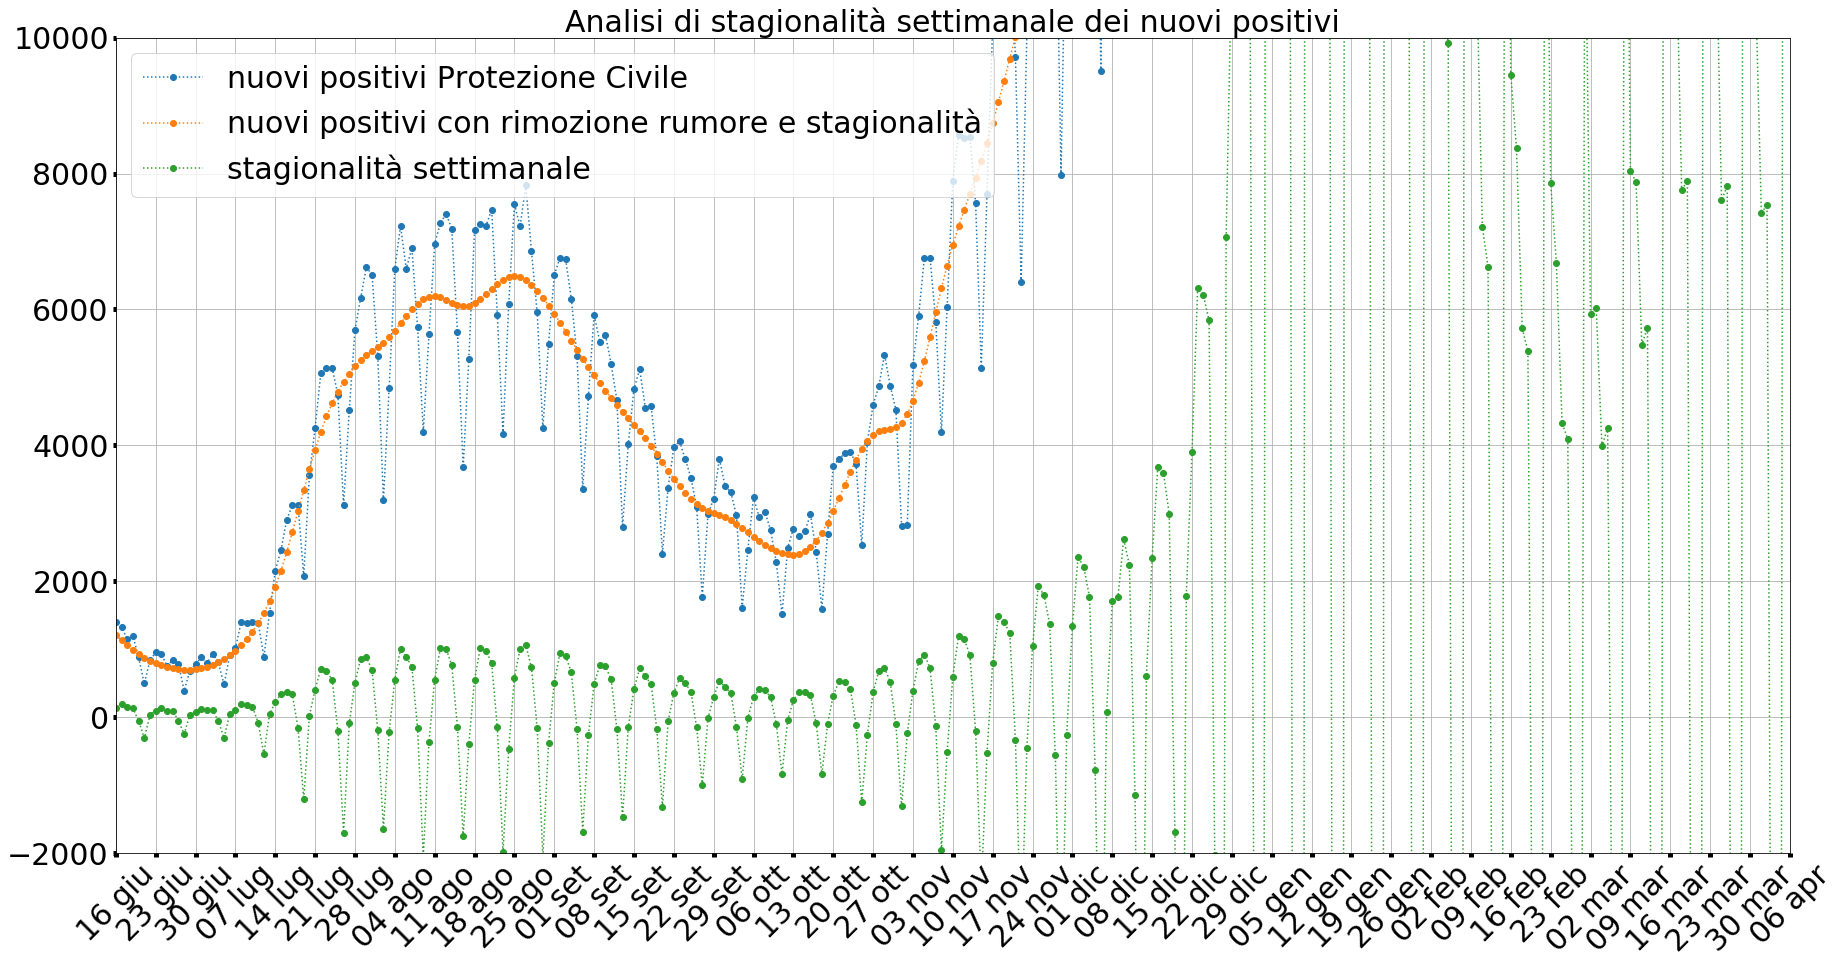

In [12]:
plotting.plot_series(
    title='Analisi di stagionalità settimanale dei nuovi positivi',
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi', 
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_deseason_seasonality'
        ],
        'labels': [
            'nuovi positivi Protezione Civile',
            'nuovi positivi con rimozione rumore e stagionalità',
            'stagionalità settimanale'
        ]
    }],
    xlim=(datetime(2021,6,16), DPC_data.data.max()),
    ylim=(-2000,10000),
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/nuovi_casi'),
    legend_loc="upper left"
)

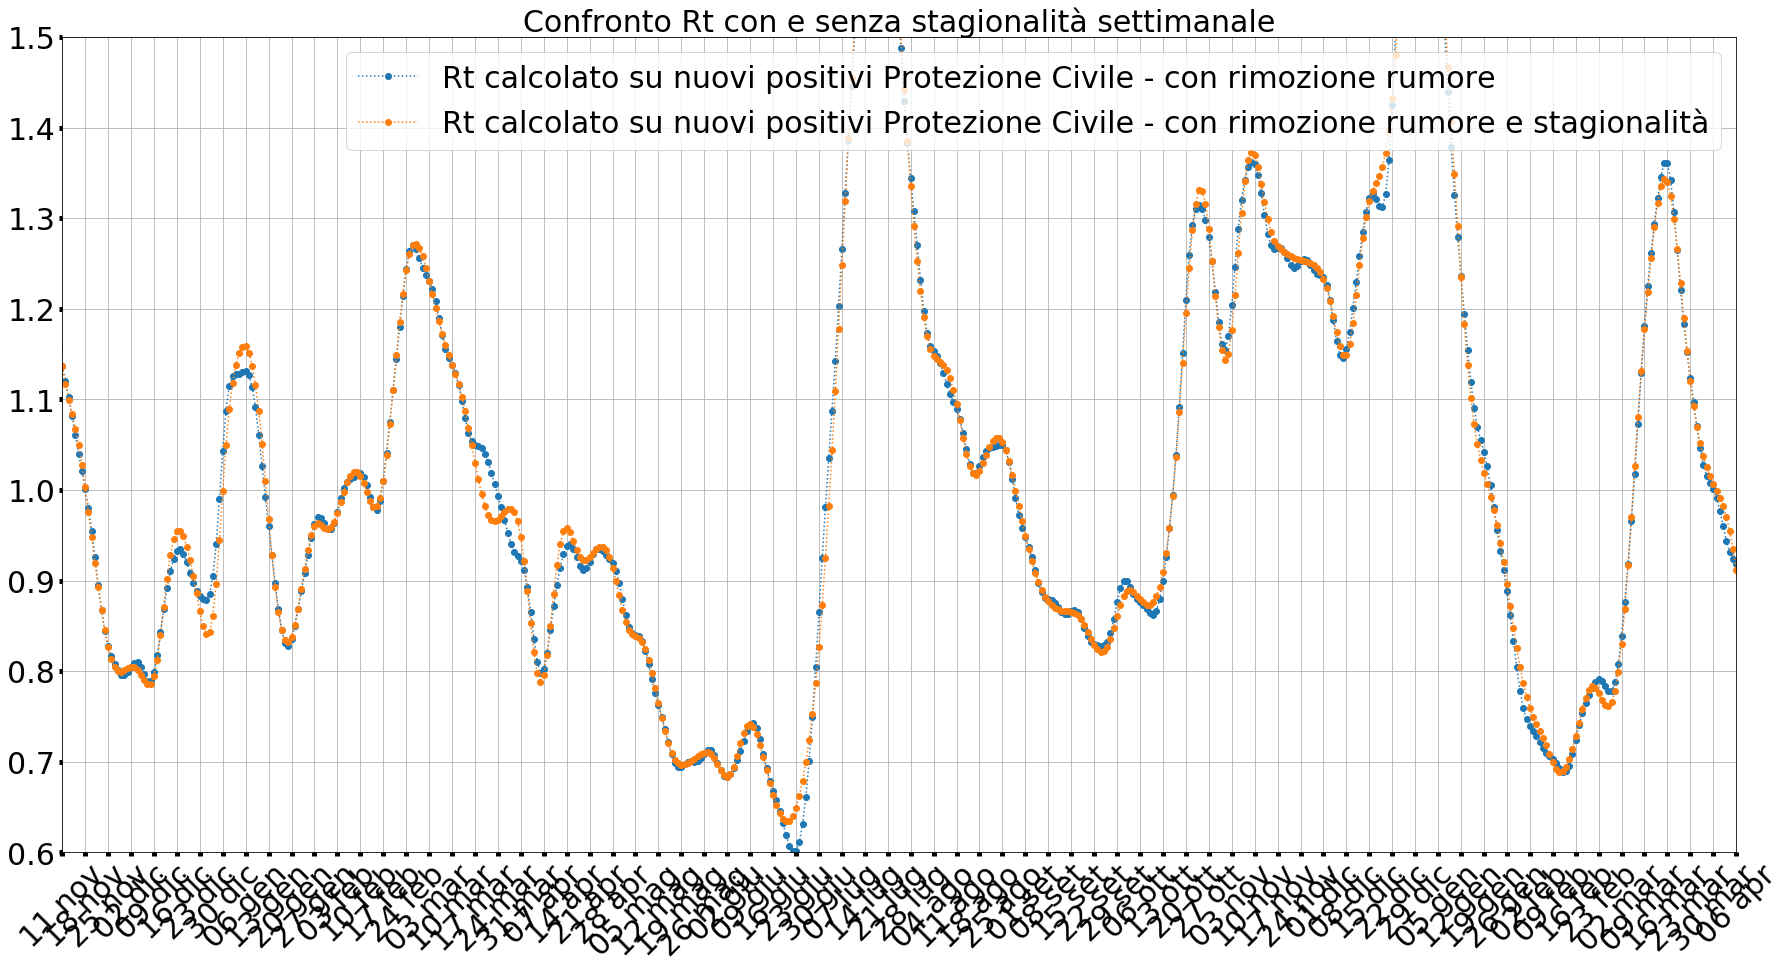

In [13]:
plotting.plot_series(
    title='Confronto Rt con e senza stagionalità settimanale',
    data=[{
        'df':DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi_smoothed_Rt',
            'nuovi_positivi_deseason_smoothed_Rt', 
        ],
        'labels':[
            'Rt calcolato su nuovi positivi Protezione Civile - con rimozione rumore',
            'Rt calcolato su nuovi positivi Protezione Civile - con rimozione rumore e stagionalità',
        ]
    }],
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'Rt_seasonality.{}'),
    xlim=(datetime(2020,11,11), DPC_data.data.max()),
    ylim=(0.6,1.5),
    legend_loc="upper right"
)

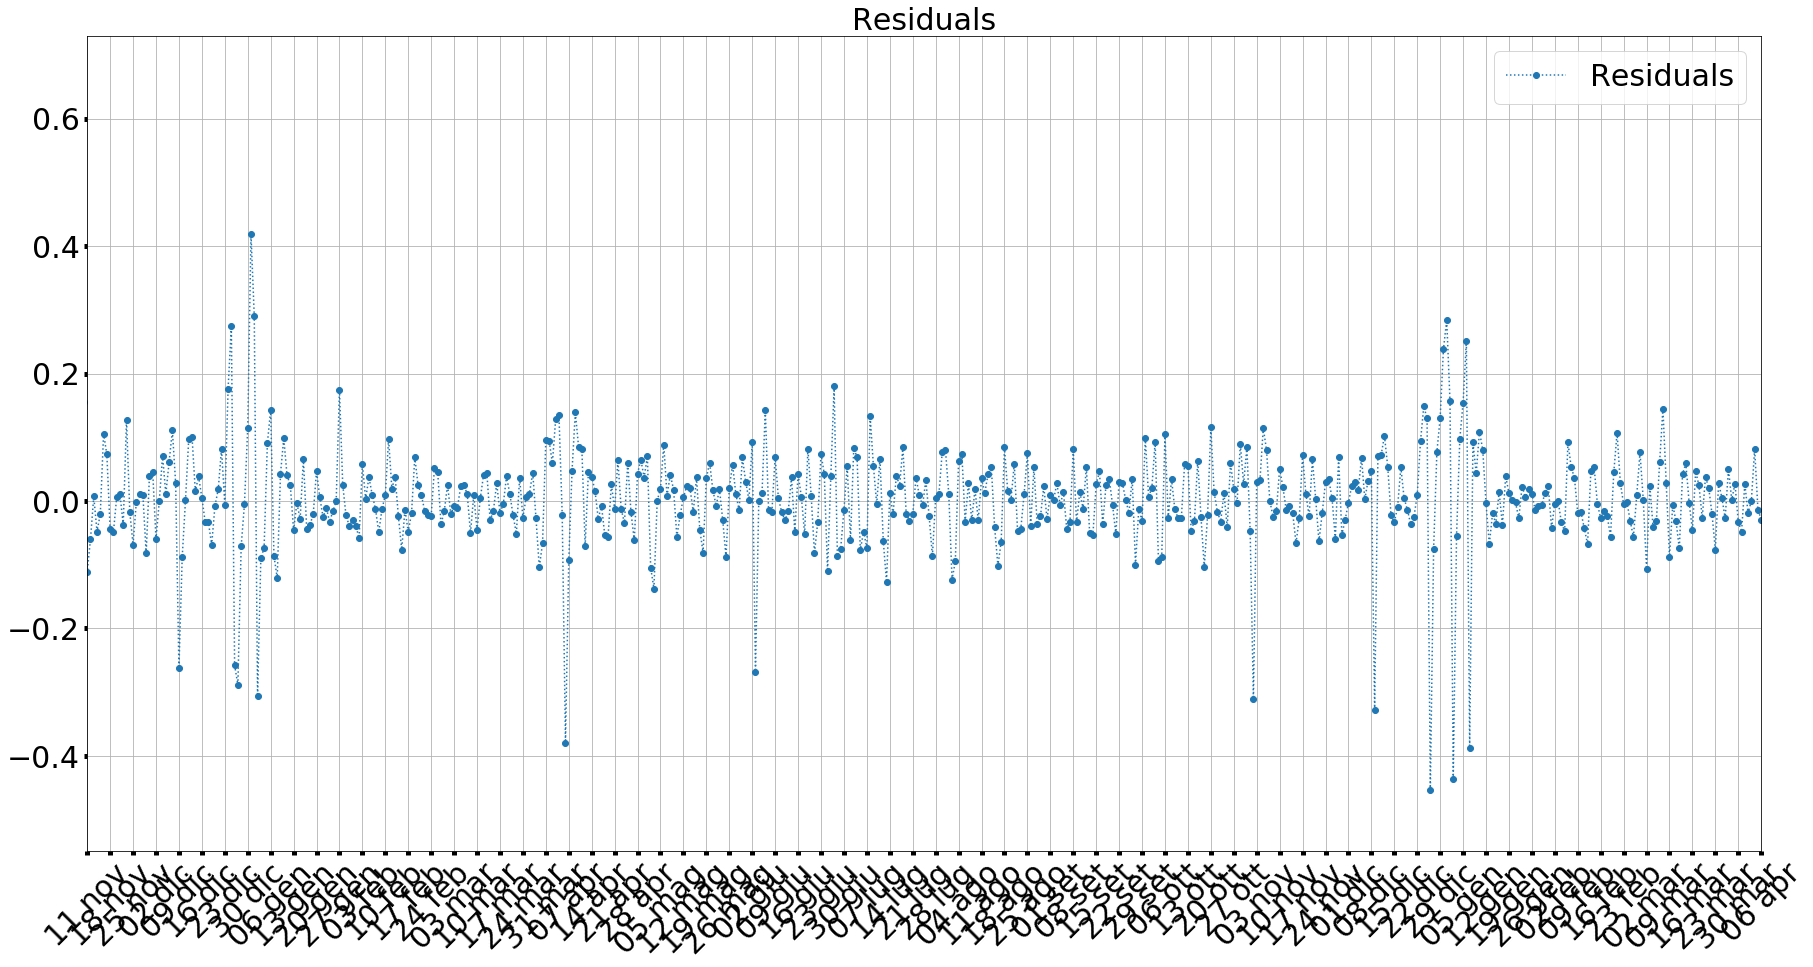

In [14]:
plotting.plot_series(
    title='Residuals',
    data=[{
        'df':DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi_deseason_relative_residuals',
        ],
        'labels':[
            'Residuals',
        ]
    }],
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'Rt_seasonality.{}'),
    xlim=(datetime(2020,11,11), DPC_data.data.max()),
    #ylim=(0.6,1.3),
    legend_loc="upper right"
)

## Distribution of residuals

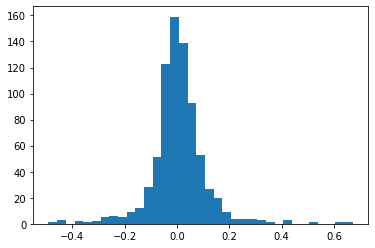

In [15]:
_=plt.hist(DPC_data.nuovi_positivi_deseason_relative_residuals,bins=35)

# Predict the next value of new cases

From the base formula for $R_t$:
$$\large{R_t = \frac{I_t}{\sum_{s=1}^t w_s I_{t-s}}}$$

we can compute the next $I_{t+1}$ value, given $R_{t+1}$:

$$\large{{I_{t+1}} = R_{t+1} \times {\sum_{s=1}^{t+1} w_s I_{t+1-s}}}$$

$$s'=s-1$$

$$\large{{I_{t+1}} = R_{t+1} {\sum_{s'=0}^{t} w_{s'+1} I_{t-s'}}}$$

Using Taylor to expand $R_{t+1}$:

$$R(t+dt) = R(t) + dR(t)dt + \frac{1}{2} d^2R(t) dt^2$$
$$R(t+\Delta t) = R(t) + \Delta R(t)\Delta t + \frac{1}{2} \Delta^2R(t) \Delta t^2$$
$$\Delta t = 1$$
$$R(t+1) = R(t) + [R(t)-R(t-1)] + \frac{1}{2} [R(t)-R(t-1)-(R(t-1)-R(t-2))]$$
$$ = 2R(t)-R(t-1) + \frac{1}{2} [R(t)-2R(t-1)+R(t-2)]$$
$$ = \frac{3}{2} R(t) - 2 R(t-1) +\frac{1}{2} R(t-2)$$

We finally have:
$$\large{{I_{t+1}} = \left[\frac{3}{2} R_t - 2 R_{t-1} +\frac{1}{2} R_{t-2} \right] {\sum_{s'=0}^{t} w_{s'+1} I_{t-s'}}}$$

# Obtain the confidence interval from the predictions

$$\large{X_t = S_t + E_t}$$

where:
- $X$ is the original signal
- $S$ is the seasonal component
- $E$ is the deseasoned component

$$\large{E_t = T_t + \epsilon_t}$$

where:
- $T$ is the smoothed trend
- $\epsilon$ is the residual

$$\large{X_{t+1}= T_{t+1} + \epsilon_{t+1} + S_{t+1}}$$

where we can approximate $X_{t+1}$ with the following:
- $T_{t+1}$ is approximated via Taylor on the previous $R_t$ knowledge
- $\epsilon_{t+1}$ is sampled from a gaussian distribution of the relative residuals, with $\mu=AVG_{t-7}(\epsilon_t/T_t)$ and $\sigma=STD_{t-7}(\epsilon_t/T_t)$

- $S_{t+1}$ is approximated with taylor from the last $S_{t+1-period}$ known value

## Strategy:

1. deseason once and obtain $T, R, S$
2. with those sample multiple values of $X_{t+1}$ based on taylor expantion and the hypotesis that tomorrow new cases can range from `0.8` to `1.2` as many the cases of today, as from $T$
3. generate multiple possible series $X^i$ with $i$ spanning the samples
4. deseason again each of the possible series
5. drop the last value as it is tomorrow
6. use the obtained $T$ as the truth value for the posterior in MCMC, adding noise sampled from $\epsilon_t$

This strategy is implemented essentially in two functions:

#### `covid19_pytoolbox.modeling.datarevision.seasonal.draw_expanded_series`:
`draw_expanded_series` performs steps 1 to 4, with as many `draws` future scenario


#### `covid19_pytoolbox.modeling.Rt.bayesian.MCMC_sample`:
`MCMC_sample` perform step 6, by sampling $R_t$ and $\epsilon_t$  in 4 chains with 500 samples each, forcing the number of new cases to be Bernoulli distributed with respect to the trend $T$.

By iterating `MCMC_sample` on each draw from the previous steps, the method can accounts for data revision, as each draw is a possibile future scenario ranging from `0.8` to `1.2` wrt the current trend $T$.

In [16]:
def save_MCMC_sampling(df, column, trace, pastdays, interval=0.95, start=0):
    interval_frac = int(interval*100)
    sampling_mean = np.mean(trace['r_t'], axis=0)

    df[f'{column}_Rt_MCMC_pastdays_{pastdays:02d}'] = padnan(sampling_mean, (start,pastdays))
    

    #credible interval
    sampling_hdi = pm.stats.hpd(trace['r_t'], hdi_prob=interval)
    df[f'{column}_Rt_MCMC_HDI_{interval_frac}_min_pastdays_{pastdays:02d}'] = padnan(
        sampling_hdi[:,0], (start,pastdays))
    df[f'{column}_Rt_MCMC_HDI_{interval_frac}_max_pastdays_{pastdays:02d}'] = padnan(
        sampling_hdi[:,1], (start,pastdays))


In [17]:
# set the following to anything grater than 0 to compute Rt series based on past days values on new cases
# this is helpful in checking how the method is robust against data revision

PASTDAYS_BEGIN=0

draws = 5

for pastdays in range(PASTDAYS_BEGIN-1,-1,-1):

    if pastdays == 0:
        sl = np.s_[:]
    else:
        sl = np.s_[:-pastdays]
        
    new_cases = DPC_data.nuovi_positivi.to_numpy()[sl]
    
    new_cases_expanded = draw_expanded_series(
            new_cases, draws=draws, season_period=7, trend_alpha=ALPHA, difference_degree=2, 
            alpha=alpha, beta=beta, truncate=False
        )
        
    new_cases_smoothed, rel_eps, padding_left = smooth_and_drop(
        new_cases_expanded, season_period=7, trend_alpha=100.,difference_degree=2)
        
    simulations = []
    for new_cases_s, rel_eps_s in zip(new_cases_smoothed, rel_eps):        
        model_, trace_ = MCMC_sample(
            onset=new_cases_s[~np.isnan(new_cases_s)],
            alpha=alpha, beta=beta,
            rel_eps=rel_eps_s[~np.isnan(rel_eps_s)],
            eps_window=1,
            start=0, window=None,
            chains=4,
            tune=500,
            draws=500,
            cores=4,
            dry=False,
            progressbar=False
        )
        simulations.append(trace_)

    sampled_Rt = np.array([t['r_t'] for t in simulations])
    combined_trace = {'r_t': sampled_Rt.reshape((-1,sampled_Rt.shape[2]))}

    save_MCMC_sampling(
        DPC_data, 'nuovi_positivi_smooth_deseas', combined_trace, pastdays, interval=0.95, start=padding_left+1)

    
    DPC_data.to_pickle(os.path.join(BASE_DATA_PATH,'computed/WIP/deseason_MCMC_Rt.pickle'))

# Calculation

The actual simulations run on virtual machines on IBM Cloud via the scripts contained in the `applications/` dir.

Here we just load the pickles generated by the simulations.

In [18]:
italy_calc_data = pd.read_pickle(
    os.path.join(BASE_DATA_PATH, 
                 f'computed/italy/{date_}_futbound_08_12_National_MCMC_Rt_pastdays_{pastdays}_{pastdays}.pickle')
)

In [19]:
italy_calc_data.sort_values(by='data', inplace=True)
italy_calc_data.reset_index(drop=True, inplace=True)

## Save computed data to csv and excel

In [20]:
procdata_to_save = italy_calc_data.loc[
    italy_calc_data.data>"2020-03-01",
    [
        "data", 
        "nuovi_positivi",
        f"nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}",
        f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}",
        f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}"
    ]
].sort_values(by="data", ascending=False)

procdata_to_save.rename(columns={
    f"nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}": "Rt",
    f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}": "Rt_interv_cred_min",
    f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}": "Rt_interv_cred_max",
}, inplace=True)

procdata_to_save.to_csv(
    os.path.join(BASE_DATA_PATH, "computed/TD-covid19-ita-andamento-nazionale_Rt.csv"),
    float_format='%.2f',
    index=False
)
procdata_to_save.to_excel(
    os.path.join(BASE_DATA_PATH, "computed/TD-covid19-ita-andamento-nazionale_Rt.xlsx"),
    float_format='%.2f',
    index=False        
)

# ISS Data

To allow for comparison with official $Rt$ calculation, we load official data from a static dataset which we update manually every week.

In [21]:
ISS_Rt = ISS.read_weekly_Rt_from_local()
ISS_Rt_clean = ISS.preprocess(ISS_Rt)
ISS_Rt_clean.tail()

computation_time_range_start computation_time_range_end    Rt  Rt_95_min  \
81                   2022-02-09                 2022-02-22  0.75       0.67   
82                   2022-02-16                 2022-03-01  0.83       0.73   
83                   2022-02-23                 2022-03-08  0.94       0.83   
84                   2022-03-02                 2022-03-15  1.12       0.87   
85                   2022-03-09                 2022-03-22  1.24       1.14   

    Rt_95_max  Rt_95_err_max  Rt_95_err_min   Rt_reference_date  
81       0.96           0.21           0.08 2022-02-15 23:59:00  
82       0.95           0.12           0.10 2022-02-22 23:59:00  
83       1.24           0.30           0.11 2022-03-01 23:59:00  
84       1.44           0.32           0.25 2022-03-08 23:59:00  
85       1.31           0.07           0.10 2022-03-15 23:59:00

In [22]:
def plot_simulation_results(
    simdf, ISSdf, xmin=datetime(2020,7,25), xmax=None, ylim=(0.2,2.5), 
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, 'TD_Rt_computation_MCMC_300dpi')):
    
    if not xmax:
        xmax = simdf.data.max()
        
    plotting.plot_series(
        title='',
        message='Aggiornamento del {}'.format(xmax.strftime('%d %b %Y')),
        data=[
            {
                'df': ISSdf,
                'xfield': 'Rt_reference_date',
                'yfields': ['Rt'],
                'bars': [['Rt_95_err_min','Rt_95_err_max']],
                'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
                'labels': ['Stima di $R_t$ pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
                'colors': ['blue']
            },        
            {
                'df': simdf,
                'xfield': 'data',
                'yfields': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}', 
                ],
                'fill_between': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}',
                ],
                'labels': [
                    f'Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
                ],
                'colors':['orange']
            },
        ],
        legend_fontsize=27,
        xlim=(xmin, xmax),
        ylim=ylim,
        legend_loc='lower right',
        img_file_path_without_extension=img_file_path_without_extension,
        dpi=150,
        quality=60,
        tick_fontsize=20,
        major_formatter=mdates.DateFormatter("%d %b %y")
    )

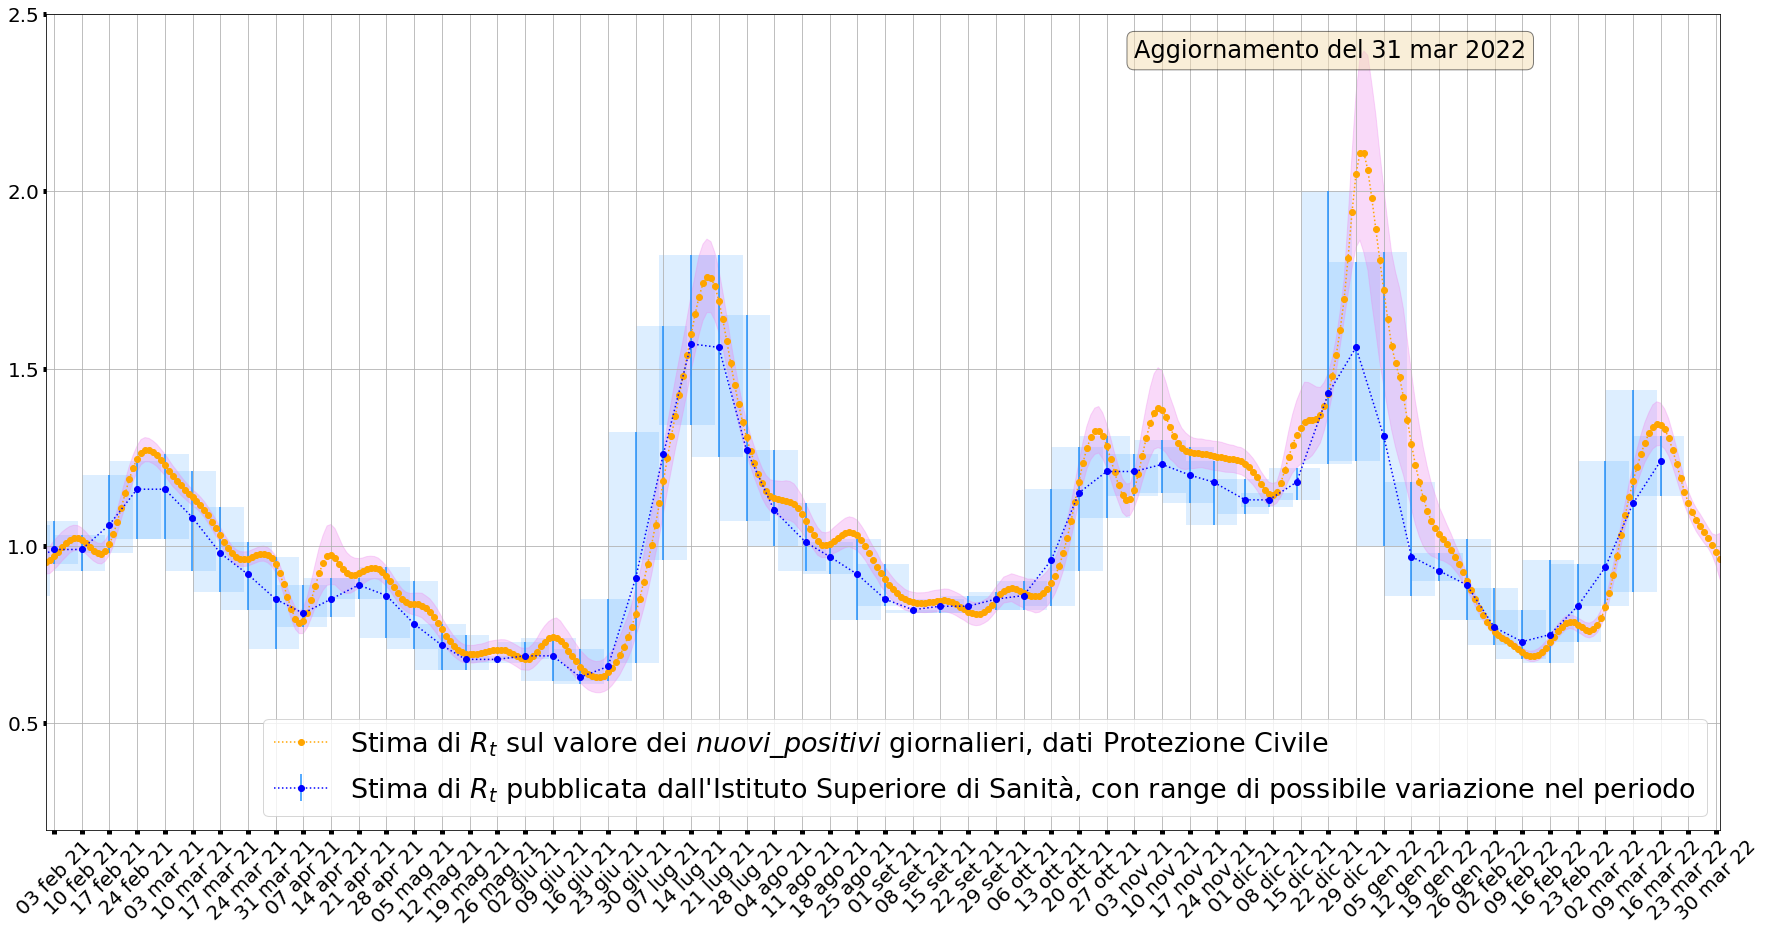

In [23]:
plot_simulation_results(
    simdf=italy_calc_data, ISSdf=ISS_Rt_clean, xmin=datetime(2021,2,1)) #, xmax=datetime(2021,11,26)

In [24]:
italy_calc_data.loc[italy_calc_data.data>'2021-01-01',['nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000']].min()

nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000    0.629293
dtype: float64

In [25]:
italy_calc_data['nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000'][100]

0.6200875789756823

In [26]:
italy_calc_data.set_index("data").tail().T

data                                                 2022-03-27   2022-03-28  \
stato                                                       ITA          ITA   
ricoverati_con_sintomi                                     9181         9496   
terapia_intensiva                                           464          487   
totale_ospedalizzati                                       9645         9983   
isolamento_domiciliare                                  1253246      1244073   
totale_positivi                                         1262891      1254056   
variazione_totale_positivi                                 8508        -8835   
nuovi_positivi                                            59555        30710   
dimessi_guariti                                        12943050     12983350   
deceduti                                                 158782       158877   
casi_da_sospetto_diagnostico                                NaN          NaN   
casi_da_screening                                           NaN          NaN   
totale_casi                                            14364723     14396283   
tamponi                                               199024140    199235675   
casi_testati                                        5.39182e+07  5.39629e+07   
note                                                        NaN          NaN   
ingressi_terapia_intensiva                                   40           39   
note_test                                                   NaN          NaN   
note_casi                                                   NaN          NaN   
totale_positivi_test_molecolare                     8.26129e+06  8.26923e+06   
totale_positivi_test_antigenico_rapido              6.10343e+06  6.12705e+06   
tamponi_test_molecolare                              8.7924e+07  8.79683e+07   
tamponi_test_antigenico_rapido                        1.111e+08  1.11267e+08   
local                                                       NaN          NaN   
imported                                                    NaN          NaN   
total                                                       NaN          NaN   
imported_ratio                                              NaN          NaN   
imported_ratio_avg14                                        NaN          NaN   
imported_ratio_std14                                        NaN          NaN   
imported_ratio_shifted                              0.000753693  0.000753693   
nuovi_positivi_corrected                                59510.1      30686.9   
nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000       1.03927      1.02212   
nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min...      1.00814     0.993944   
nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max...      1.07106      1.05201   

data                                                 2022-03-29   2022-03-30  \
stato                                                       ITA          ITA   
ricoverati_con_sintomi                                     9740         9871   
terapia_intensiva                                           487          481   
totale_ospedalizzati                                      10227        10352   
isolamento_domiciliare                                  1256651      1272464   
totale_positivi                                         1266878      1282816   
variazione_totale_positivi                                12822        15938   
nuovi_positivi                                            99457        77621   
dimessi_guariti                                        13070647     13125950   
deceduti                                                 159054       159224   
casi_da_sospetto_diagnostico                                NaN          NaN   
casi_da_screening                                           NaN          NaN   
totale_casi                                            14496579     14567990   
tamponi                                               199896383    200421282   

In [27]:
italy_calc_data.tail(10)

data stato  ricoverati_con_sintomi  terapia_intensiva  \
757 2022-03-22   ITA                    8969                455   
758 2022-03-23   ITA                    8939                466   
759 2022-03-24   ITA                    9029                447   
760 2022-03-25   ITA                    8994                447   
761 2022-03-26   ITA                    9023                452   
762 2022-03-27   ITA                    9181                464   
763 2022-03-28   ITA                    9496                487   
764 2022-03-29   ITA                    9740                487   
765 2022-03-30   ITA                    9871                481   
766 2022-03-31   ITA                    9898                468   

     totale_ospedalizzati  isolamento_domiciliare  totale_positivi  \
757                  9424                 1191183          1200607   
758                  9405                 1217485          1226890   
759                  9476                 1236327          1245803   
760                  9441                 1236840          1246281   
761                  9475                 1244908          1254383   
762                  9645                 1253246          1262891   
763                  9983                 1244073          1254056   
764                 10227                 1256651          1266878   
765                 10352                 1272464          1282816   
766                 10366                 1266678          1277044   

     variazione_totale_positivi  nuovi_positivi  dimessi_guariti  ...  \
757                       25327           96365         12633384  ...   
758                       26283           76260         12685306  ...   
759                       18913           81811         12748859  ...   
760                         478           75616         12824632  ...   
761                        8102           73357         12891028  ...   
762                        8508           59555         12943050  ...   
763                       -8835           30710         12983350  ...   
764                       12822           99457         13070647  ...   
765                       15938           77621         13125950  ...   
766                       -5772           73195         13205927  ...   

     imported  total  imported_ratio  imported_ratio_avg14  \
757       NaN    NaN             NaN                   NaN   
758       NaN    NaN             NaN                   NaN   
759       NaN    NaN             NaN                   NaN   
760       NaN    NaN             NaN                   NaN   
761       NaN    NaN             NaN                   NaN   
762       NaN    NaN             NaN                   NaN   
763       NaN    NaN             NaN                   NaN   
764       NaN    NaN             NaN                   NaN   
765       NaN    NaN             NaN                   NaN   
766       NaN    NaN             NaN                   NaN   

     imported_ratio_std14  imported_ratio_shifted nuovi_positivi_corrected  \
757                   NaN                0.000754             96292.370365   
758                   NaN                0.000754             76202.523364   
759                   NaN                0.000754             81749.339614   
760                   NaN                0.000754             75559.008743   
761                   NaN                0.000754             73301.711336   
762                   NaN                0.000754             59510.113808   
763                   NaN                0.000754             30686.854085   
764                   NaN                0.000754             99382.039946   
765                   NaN                0.000754             77562.497588   
766                   NaN                0.000754             73139.833434   

     nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000  \
757                                           1.153552   
758                                    

In [28]:
italy_calc_data.loc[
    italy_calc_data[(italy_calc_data.data>"2022-03-02")].nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000.idxmax()
]

data                                                            2022-03-15 00:00:00
stato                                                                           ITA
ricoverati_con_sintomi                                                         8473
terapia_intensiva                                                               502
totale_ospedalizzati                                                           8975
isolamento_domiciliare                                                      1027149
totale_positivi                                                             1036124
variazione_totale_positivi                                                    32885
nuovi_positivi                                                                85288
dimessi_guariti                                                            12296018
deceduti                                                                     157177
casi_da_sospetto_diagnostico                                                

# compare $R_t$ and new admissions

In [29]:
# this does not work until upgrading pandas to 1.3.5

#ISS_XLSX_FILE=os.path.join(BASE_DATA_PATH, 'sources/ISS/covid_19-iss_2022-01-18T22:37:04+00:00.xlsx')
#SHEET = "ricoveri"
#fxlsx = pd.ExcelFile(ISS_XLSX_FILE,engine="openpyxl")
#if SHEET in fxlsx.sheet_names:
#    ricoveri = pd.read_excel(ISS_XLSX_FILE, sheet_name=SHEET, engine="openpyxl")


In [30]:
ricoveri = pd.read_csv(
    os.path.join(BASE_DATA_PATH, 'sources/ISS/covid_19-iss_2022-04-05T22:34:38+00:00.ricoveri.csv'),
    #parse_dates=['iss_date', 'DATARICOVERO1']
)

ricoveri.loc[ricoveri.RICOVERI=='<5',['RICOVERI']]=5
ricoveri.RICOVERI = ricoveri.RICOVERI.astype(int)
ricoveri.dropna(inplace=True)

ricoveri['data']= pd.to_datetime(
    ricoveri.DATARICOVERO1,
    format='%d/%m/%Y'
)

ricoveri.sort_values(by='data', inplace=True)
ricoveri.reset_index(drop=True, inplace=True)


In [31]:
ricoveri_stable = ricoveri.loc[ricoveri.data<"2022-03-29"].copy()

RSVD_smooth_data_generic(
    ricoveri_stable, ['RICOVERI'], 
    alpha, beta, 
    season_period=7, trend_alpha=100, difference_degree=4)

['RICOVERI']
RICOVERI_deseason
info_cri:  -1.0082212420951677
info_cri:  3.9046051867383773
TIC R2: 0.9909970679874247
patterns: 1
(   -16.60053082559516,
    1.7661534139536866e-29,
    20,
    738,
    {   '1%': -3.4392418578608983,
        '10%': -2.568859710342903,
        '5%': -2.86546426916434},
    -993.4159253534856)
new columns generated:
[   'RICOVERI_deseason',
    'RICOVERI_deseason_seasonality',
    'RICOVERI_deseason_smoothed',
    'RICOVERI_deseason_residuals',
    'RICOVERI_deseason_relative_residuals',
    'RICOVERI_deseason_smoothed_Rt']


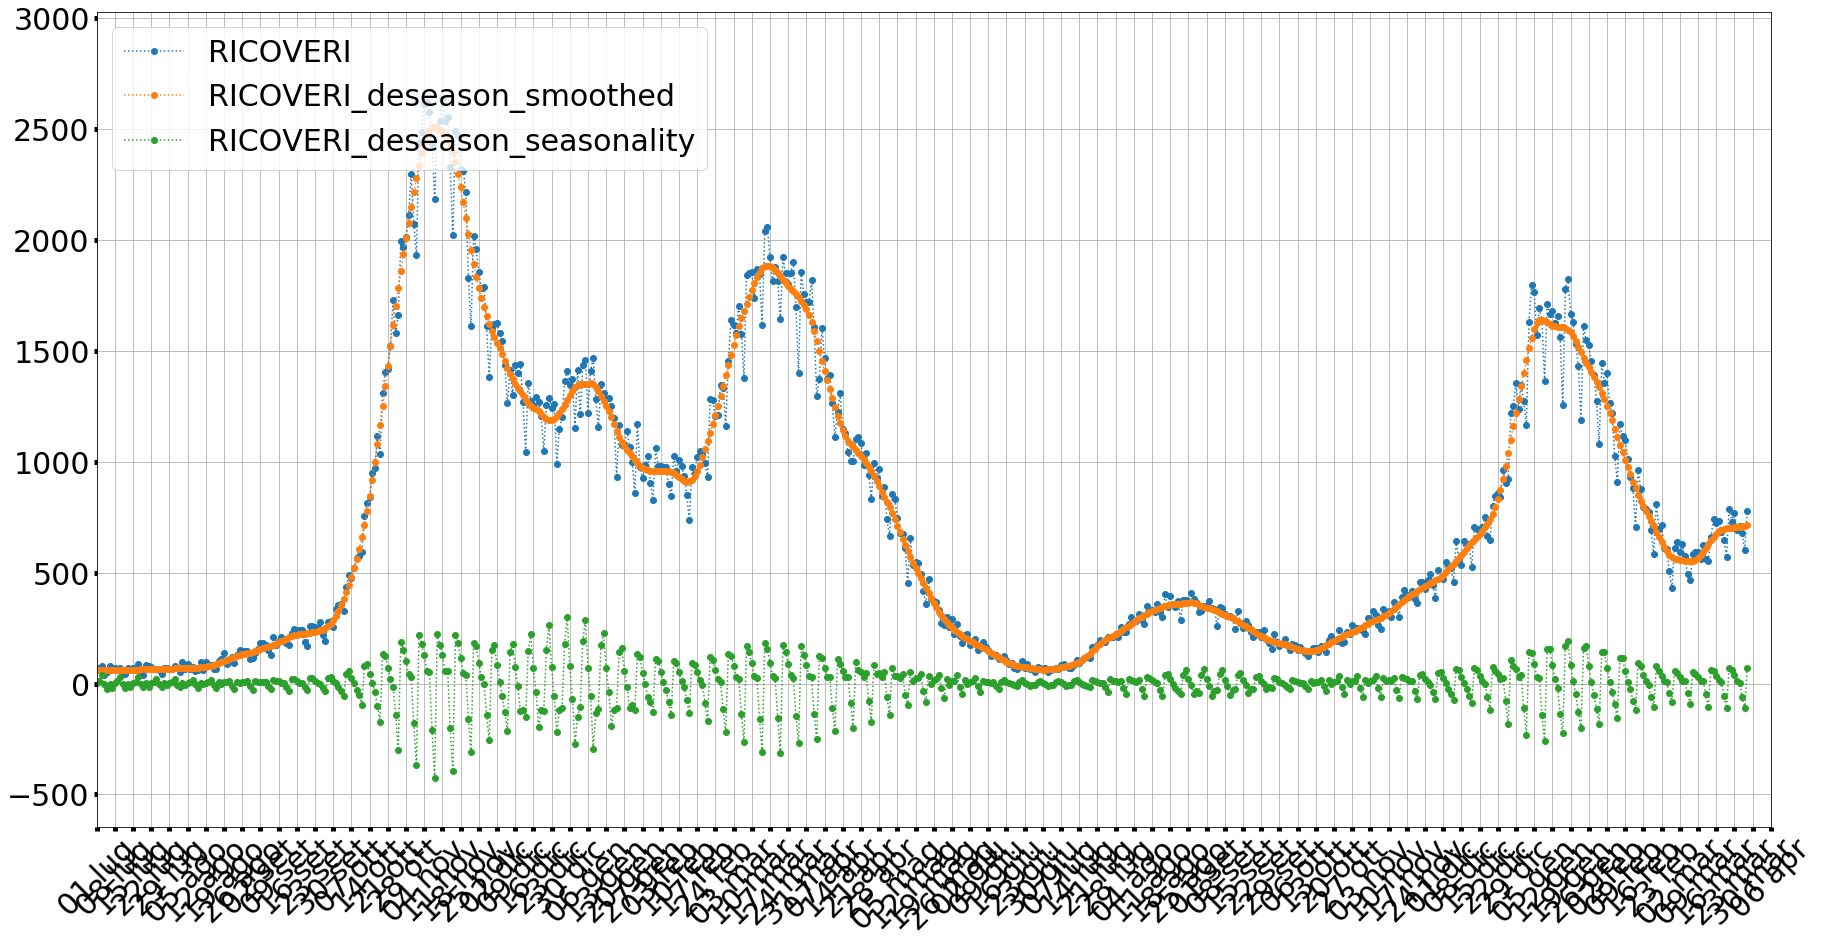

In [32]:
plotting.plot_series(
    df=ricoveri_stable,
    yfields=[
        'RICOVERI', 
        'RICOVERI_deseason_smoothed',
        'RICOVERI_deseason_seasonality'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2020,7,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

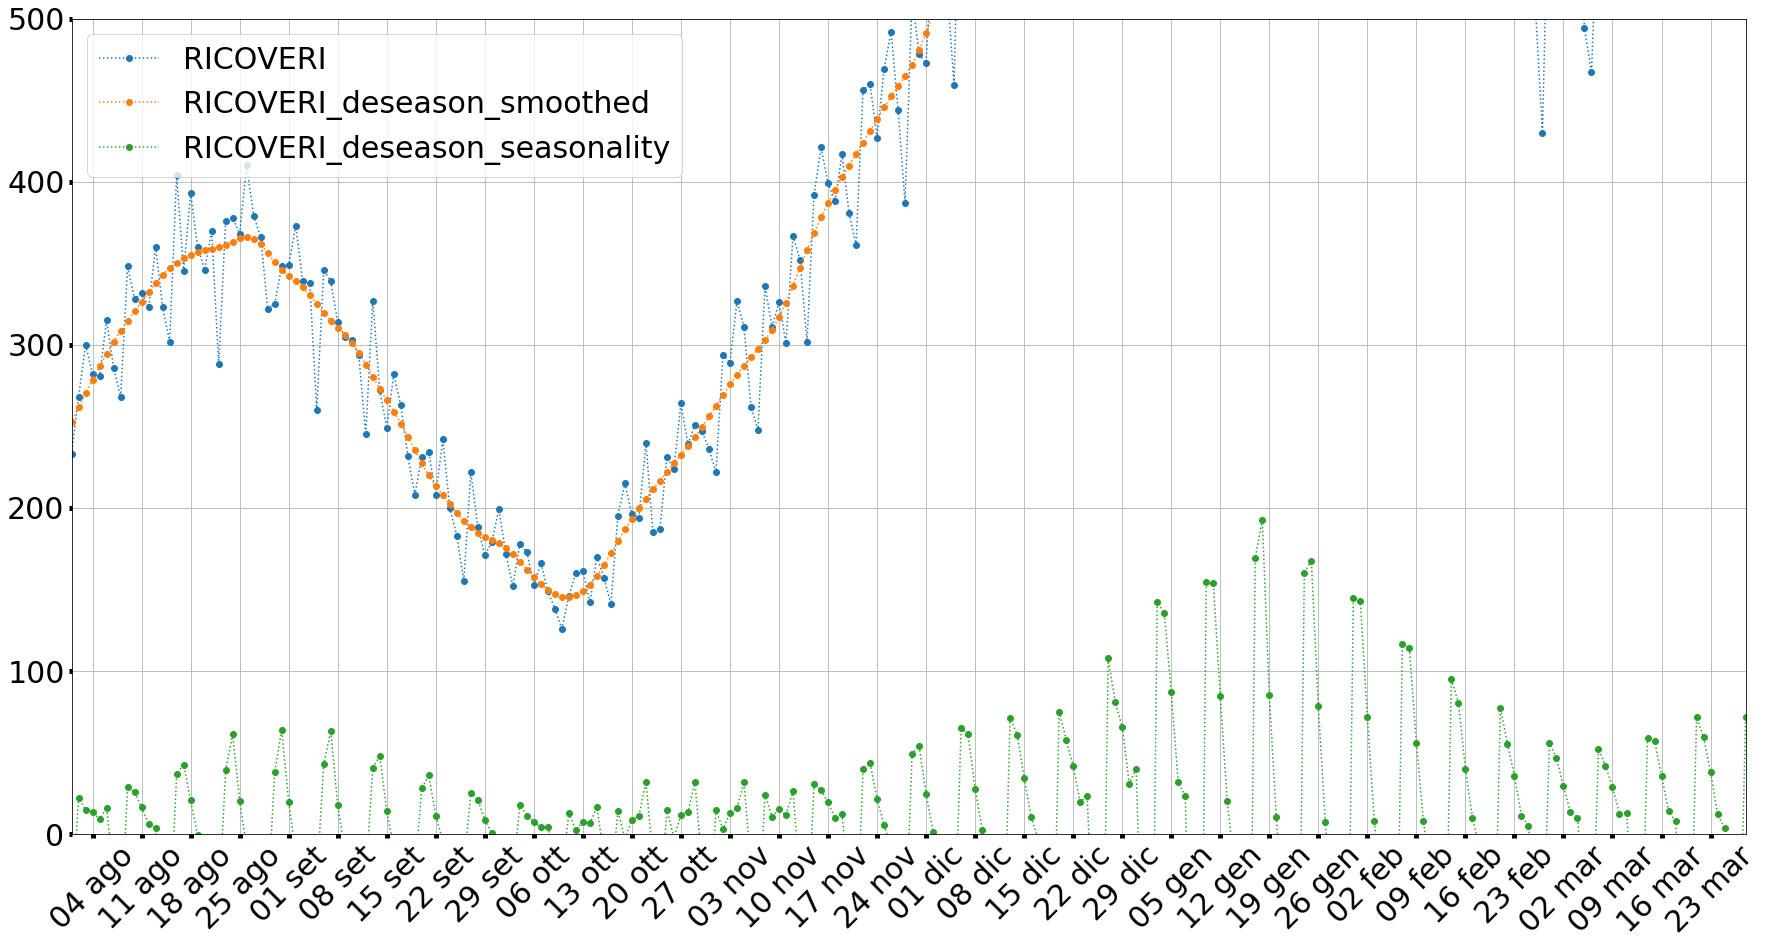

In [33]:
plotting.plot_series(
    df=ricoveri_stable,
    yfields=[
        'RICOVERI', 
        'RICOVERI_deseason_smoothed',
        'RICOVERI_deseason_seasonality'
    ],
    xlim=(datetime(2021,8,1), ricoveri_stable.data.max()),
    ylim=(0,500),
    legend_loc="upper left"
)

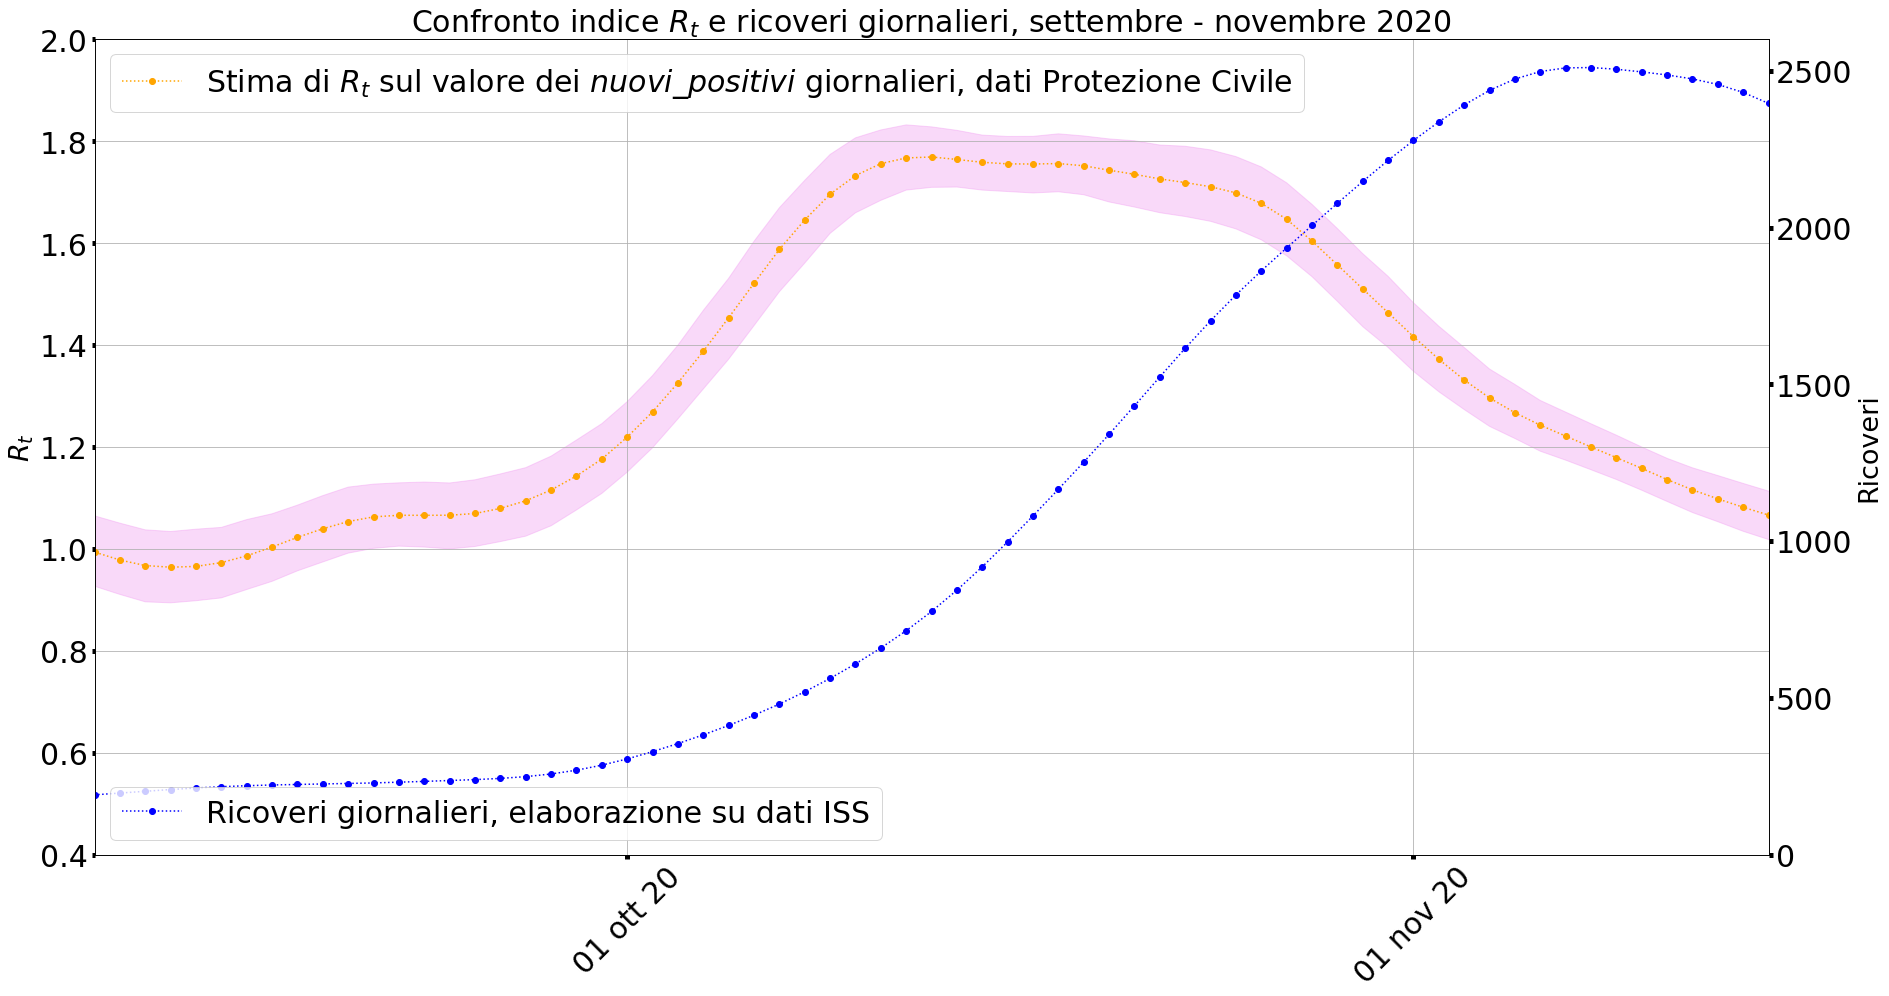

In [34]:
plotting.plot_series(
    title='Confronto indice $R_t$ e ricoveri giornalieri, settembre - novembre 2020',
    data=[
        {
            'df': italy_calc_data,
            'xfield': 'data',
            'yfields': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}', 
            ],
            'fill_between': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}',
            ],
            'labels': [
                f'Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
            ],
            'colors':['orange']
        },
        {
            'df': ricoveri_stable,
            'xfield': 'data',
            'yfields': ['RICOVERI_deseason_smoothed'],
            'colors': ['blue'],
            'secondary_ylim': (0,2600),
            'secondary_ylabel': "Ricoveri",
            'labels':['Ricoveri giornalieri, elaborazione su dati ISS']
        },        
    ],
    xlim=(datetime(2020,9,10), datetime(2020,11,15)),#DPC_data.data.max()),
    ylim=(0.4,2),
    y_label='$R_t$',
    #ylim=(-10000,40000),
    legend_loc="upper left",
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, "italy/confr_rt_con_ricoveri_set_nov_2020"),
    dpi=150,
    quality=60
    
)


In [35]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-09-30")&(ricoveri_stable.data<="2020-10-06")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 285.7402534356087 445.0791183783347 159.33886494272605 55.76353454821616


In [36]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-10-06")&(ricoveri_stable.data<"2020-10-13")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 445.0791183783347 714.5606365621101 269.48151818377534 60.54687965718164


In [37]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-10-13")&(ricoveri_stable.data<"2020-10-20")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 775.8991417497512 1252.1546333437104 476.2554915939593 61.381108183718645


In [38]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-10-20")&(ricoveri_stable.data<"2020-10-27")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 1340.7669136463778 1861.964654479876 521.1977408334981 38.87310579704251


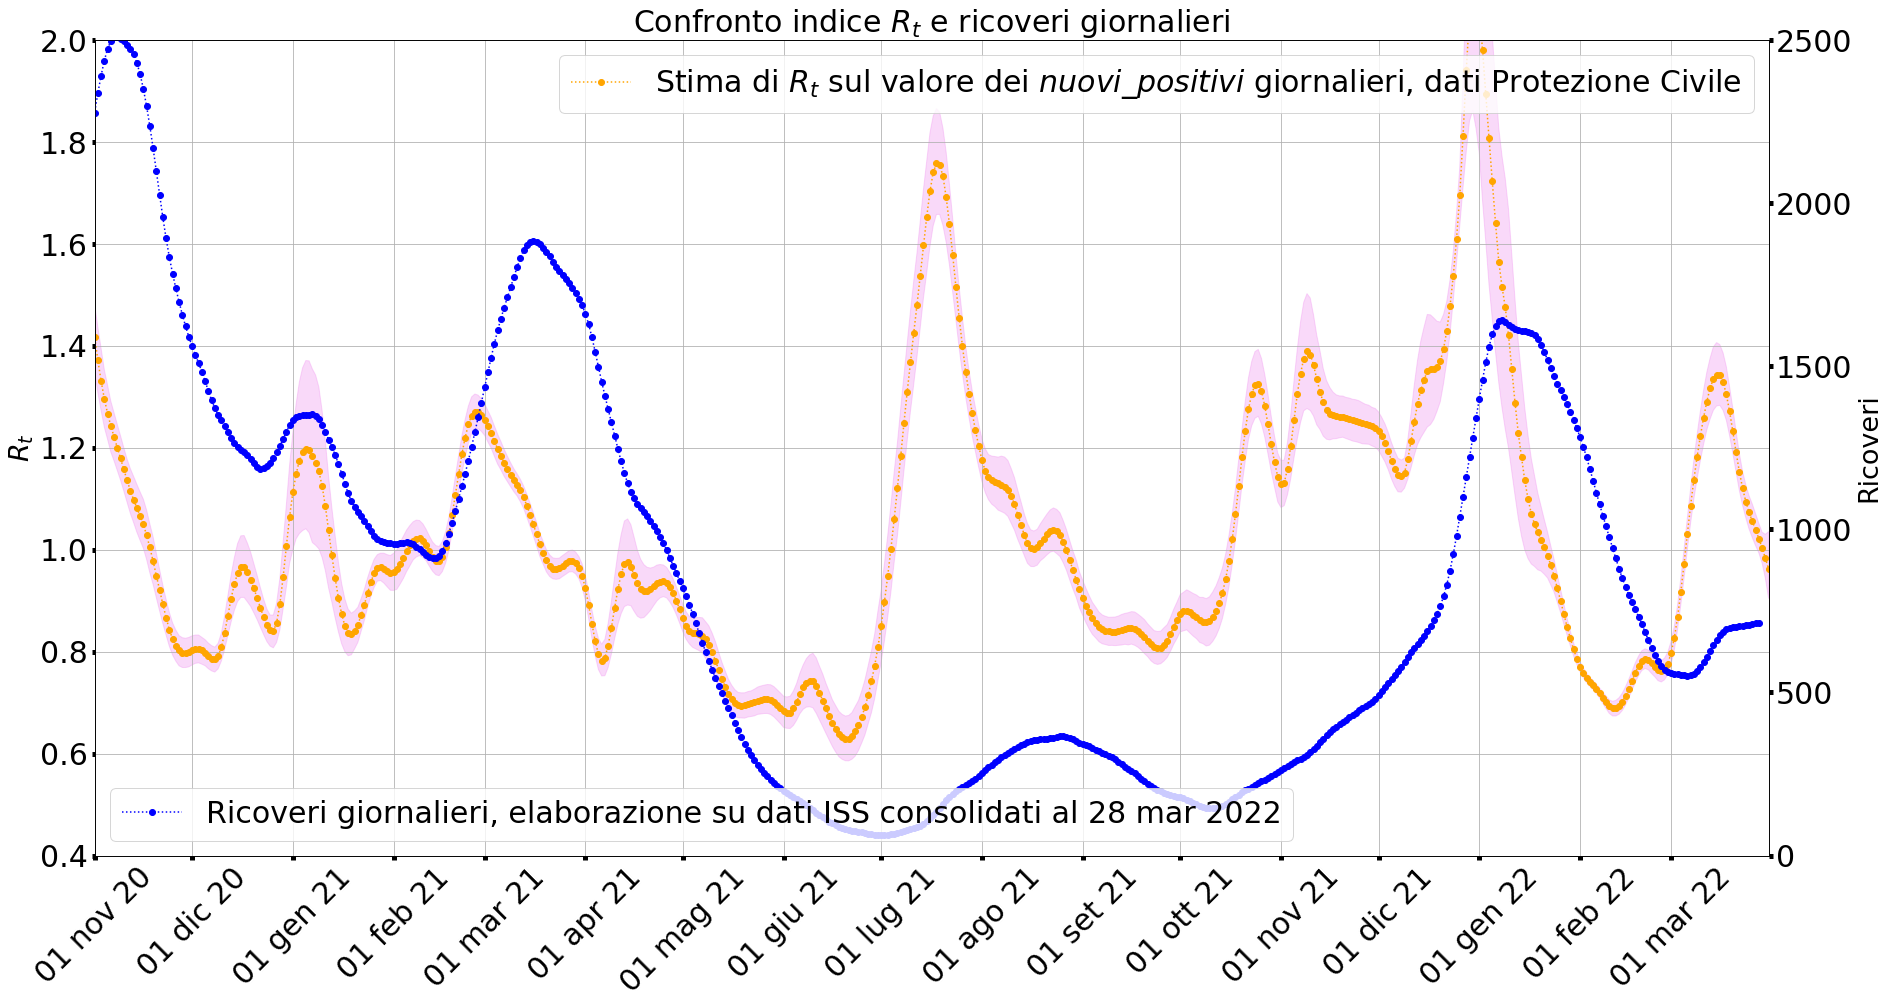

In [39]:
plotting.plot_series(
    title='Confronto indice $R_t$ e ricoveri giornalieri',
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%d %b"),    
    data=[
        {
            'df': italy_calc_data,
            'xfield': 'data',
            'yfields': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}', 
            ],
            'fill_between': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}',
            ],
            'labels': [
                f'Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
            ],
            'colors':['orange']
        },
        {
            'df': ricoveri_stable, #ricoveri[ricoveri.data<="2021-07-11"],
            'xfield': 'data',
            'yfields': ['RICOVERI_deseason_smoothed'],
            'colors': ['blue'],
            'secondary_ylim': (0,2500),
            'secondary_ylabel': "Ricoveri",
            'labels':[f'Ricoveri giornalieri, elaborazione su dati ISS consolidati al {ricoveri_stable.data.max().strftime("%d %b %Y")}']
        },        
    ],
    xlim=(datetime(2020,11,1), italy_calc_data.data.max()),
    ylim=(0.4,2),
    y_label='$R_t$',
    #tick_fontsize=22,
    #ylim=(-10000,40000),
    legend_loc="upper right",
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, "italy/confr_rt_con_ricoveri_2021_2022"),
    dpi=150,
    quality=60,
)


In [40]:
ricoveri_stable[(ricoveri_stable.data<="2022-03-10")&(ricoveri_stable.data>="2022-02-20")]

iss_date DATARICOVERO1  RICOVERI       data  RICOVERI_deseason  \
731  05/04/2022    20/02/2022       582 2022-02-20         686.433849   
732  05/04/2022    21/02/2022       811 2022-02-21         733.806827   
733  05/04/2022    22/02/2022       699 2022-02-22         643.597085   
734  05/04/2022    23/02/2022       715 2022-02-23         679.571951   
735  05/04/2022    24/02/2022       612 2022-02-24         600.721356   
736  05/04/2022    25/02/2022       607 2022-02-25         601.954441   
737  05/04/2022    26/02/2022       506 2022-02-26         550.072417   
738  05/04/2022    27/02/2022       430 2022-02-27         511.086308   
739  05/04/2022    28/02/2022       613 2022-02-28         556.932363   
740  05/04/2022    01/03/2022       638 2022-03-01         591.427433   
741  05/04/2022    02/03/2022       595 2022-03-02         565.754559   
742  05/04/2022    03/03/2022       627 2022-03-03         613.671318   
743  05/04/2022    04/03/2022       573 2022-03-04         562.921318   
744  05/04/2022    05/03/2022       494 2022-03-05         536.645320   
745  05/04/2022    06/03/2022       467 2022-03-06         557.169109   
746  05/04/2022    07/03/2022       582 2022-03-07         529.833234   
747  05/04/2022    08/03/2022       592 2022-03-08         550.143944   
748  05/04/2022    09/03/2022       591 2022-03-09         562.036931   
749  05/04/2022    10/03/2022       563 2022-03-10         550.452046   

     RICOVERI_deseason_seasonality  RICOVERI_deseason_smoothed  \
731                    -104.433849                  709.404340   
732                      77.193173                  685.465835   
733                      55.402915                  661.038093   
734                      35.428049                  637.125636   
735                      11.278644                  614.947507   
736                       5.045559                  595.820173   
737                     -44.072417                  580.718650   
738                     -81.086308                  570.067204   
739                      56.067637                  563.485352   
740                      46.572567                  559.797566   
741                      29.245441                  557.581812   
742                      13.328682                  555.748769   
743                      10.078682                  553.827593   
744                     -42.645320                  552.183369   
745                     -90.169109                  551.690014   
746                      52.166766                  553.330885   
747                      41.856056                  557.977449   
748                      28.963069                  566.115357   
749                      12.547954                  577.783463   

     RICOVERI_deseason_residuals  RICOVERI_deseason_relative_residuals  \
731                   -22.970491                             -0.032380   
732                    48.340992                              0.070523   
733                   -17.441009                             -0.026384   
734                    42.446315                              0.066622   
735                   -14.226151                             -0.023134   
736                     6.134268                              0.010296   
737                   -30.646233                             -0.052773   
738                   -58.980896                             -0.103463   
739                    -6.552989                             -0.011629   
740                    31.629866                              0.056502   
741                     8.172747                              0.014657   
742                    57.922549                              0.104224   
743                     9.093725                              0.016420   
744                   -15.538050                             -0.028139   
745                     5.479095                              0.009931   
746                   -23.497651         

In [41]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-11")&(ricoveri_stable.data<"2021-07-18")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 83.03729561373419 123.85208984931585 40.81479423558166 49.152364529596966


In [42]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-18")&(ricoveri_stable.data<"2021-07-24")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(6, 10) 134.71673955377258 189.94529696523446 55.22855741146188 40.99606150980015


In [43]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-24")&(ricoveri_stable.data<"2021-07-31")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 198.21311578266443 235.6655461002384 37.45243031757397 18.89503132509132


In [44]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-08-09")&(ricoveri_stable.data<"2021-08-16")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 314.6821085059429 346.99256403799825 32.31045553205536 10.267649370172299


In [45]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-14")&(ricoveri_stable.data<"2021-07-21")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 97.4522025608391 157.82608944541144 60.37388688457234 61.95230615427201


In [46]:
filt=ricoveri_stable[(ricoveri_stable.data>"2021-07-16")&(ricoveri_stable.data<="2021-07-23")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 123.85208984931585 189.94529696523446 66.09320711591862 53.36462807880808


In [47]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-24")&(ricoveri_stable.data<"2021-07-31")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 198.21311578266443 235.6655461002384 37.45243031757397 18.89503132509132


In [48]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-08-20")&(ricoveri_stable.data<="2021-09-04")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(16, 10) 330.4211348116049 366.16510497473456 35.74397016312969 10.817700926882209
